In [1]:
import os
import tensorflow as tf
import numpy as np

from transformers import BertTokenizer, TFBertModel

In [39]:
import matplotlib.pyplot as plt

## Prepare aligned sentence pairs

In [19]:
l1 = 'de'
l2 = 'en'
l_pair = f"{l1}-{l2}"

gold_alignment = list()
with open(f'bucc2017/{l_pair}/{l_pair}.sample.gold', 'r') as in_file:
    for line in in_file.readlines(): 
        l1_tag, l2_tag = line.strip().split('\t')
        gold_alignment.append((l1_tag, l2_tag)) 
        

l1_2sent = dict()
with open(f'bucc2017/{l_pair}/{l_pair}.sample.{l1}', 'r') as l1_in:
    for line in l1_in.readlines():
        l1_tag, l1_sent = line.strip().split('\t')
        l1_2sent[l1_tag] = l1_sent
        
l2_2sent = dict()
with open(f'bucc2017/{l_pair}/{l_pair}.sample.{l2}', 'r') as l2_in:
    for line in l2_in.readlines():
        l2_tag, l2_sent = line.strip().split('\t')
        l2_2sent[l2_tag] = l2_sent
        
    
        
l1_list = []
l2_list = []
for l1_tag, l2_tag in gold_alignment:
    l1_list.append(l1_2sent[l1_tag])
    l2_list.append(l2_2sent[l2_tag])

## Initialize BERT model

In [20]:
bert_path = 'bert-base-multilingual-cased'
tokenizer = BertTokenizer.from_pretrained(bert_path, do_lower_case=False)

bert_model = TFBertModel.from_pretrained(bert_path, output_hidden_states=True)

layer_idx = 6 

In [21]:
def get_embeddings(tokenizer, bert_model, layer_idx, sent_list):
    bert_input = tokenizer.batch_encode_plus(sent_list, pad_to_max_length=True)
    input_ids = tf.constant(bert_input['input_ids'])
    attn_masks =  tf.constant(bert_input['attention_mask'])

    data = tf.data.Dataset.from_tensor_slices((input_ids, attn_masks))

    emb_list = []
    for input_batch, attn_batch in data.batch(20):
        _, _, embs = bert_model(input_batch, attention_mask=attn_batch)
        embs = tf.reduce_mean(embs[layer_idx + 1], axis=1)
        emb_list.append(embs)

    return tf.concat(emb_list, axis=0).numpy()
    

In [22]:
l1_embeddings = get_embeddings(tokenizer, bert_model, layer_idx, l1_list)

In [23]:
l2_embeddings = get_embeddings(tokenizer, bert_model, layer_idx, l2_list)

## Alignment expermients

In [24]:
def calc_alignment_accuracy(src_embeddings, tgt_embeddings):
    distance_matrix = src_embeddings @ tgt_embeddings.transpose()
    distance_matrix = distance_matrix / np.linalg.norm(src_embeddings, axis=1, keepdims=True) 
    distance_matrix = distance_matrix / np.linalg.norm(tgt_embeddings.transpose(), axis=0, keepdims=True)
    
    retived_idcs = np.argmax(distance_matrix, axis=1)
    
    src_errors = np.where(np.arange(len(retived_idcs)) != retived_idcs)
    tgt_errors = retived_idcs[src_errors]
    
    return np.mean(np.arange(len(retived_idcs)) == retived_idcs), src_errors[0], tgt_errors

def pint_error_examples(src_errors, tgt_errors, src_list, tgt_list, n_exmpl=5):
    for s_e, t_e in zip(src_errors[:n_exmpl], tgt_errors[:n_exmpl]):
        print(f"For sentence:\t{src_list[s_e]}")
        print(f"retived:\t{tgt_list[t_e]}")
        print(f"should be:\t{tgt_list[s_e]}\n")
    

### DE/FR -> EN retival

In [25]:
xx2en_acc, src_e, tgt_e = calc_alignment_accuracy(l1_embeddings, l2_embeddings)

In [26]:
print(xx2en_acc)

0.9277456647398844


de -> en 92.8%

fr -> en 90.7%

score is already quite high with BERT alone
example of errors:

In [27]:
pint_error_examples(src_e, tgt_e, l1_list, l2_list)

For sentence:	Allein in den letzten zwölf Jahren ist die Weltbevölkerung um eine Milliarde Menschen gewachsen.
retived:	Over the past few decades, an estimated two billion people have risen into the middle class worldwide.
should be:	A billion people joined the human race in just the last 12 years.

For sentence:	Ungefähr 1 Million Menschen werden demnächst in China und Indien pro Jahr an den Folgen des Rauchens sterben.
retived:	In fact, nine million people develop the active disease every year, and one in five will die.
should be:	About 1 million people per year will soon die from smoking in China and India.

For sentence:	Aber dennoch leben mehr als eine Milliarde Menschen weltweit in extremer Armut.
retived:	Yet, despite great natural wealth, a majority of people in these countries lives in poverty.
should be:	But that still leaves more than one billion people worldwide living in extreme poverty.

For sentence:	Beispielsweise sollte die Rolle des US-Dollar im internationalen Geldsy

### EN -> DE retival

In [28]:
en2xx_acc, src_e, tgt_e = calc_alignment_accuracy(l2_embeddings, l1_embeddings)

In [29]:
print(en2xx_acc)

0.896917148362235


en -> de 89.7%

en -> fr 90.3%


score for this direction is lower but still close to 90%

In [30]:
pint_error_examples(src_e, tgt_e, l2_list, l1_list)

For sentence:	A billion people joined the human race in just the last 12 years.
retived:	In den nächsten 25 Jahren werden weitere zwei Milliarden Menschen die Entwicklungsländer bevölkern.
should be:	Allein in den letzten zwölf Jahren ist die Weltbevölkerung um eine Milliarde Menschen gewachsen.

For sentence:	About 1 million people per year will soon die from smoking in China and India.
retived:	Im Lauf dieser 12 Jahre sind etwa acht Millionen Kinder auf aller Welt an Vitamin-A-Unterversorgung gestorben.
should be:	Ungefähr 1 Million Menschen werden demnächst in China und Indien pro Jahr an den Folgen des Rauchens sterben.

For sentence:	And we could believe that every single country will fulfill every single promise.
retived:	Es ist eine trostlose Wahl: Für wenige hundert Millionen Dollar könnten wir fast der Hälfte der Menschheit jetzt helfen.
should be:	Und wir könnten überdies davon ausgehen, dass jedes einzelne Land jedes einzelne seiner Versprechen einlöst.

For sentence:	But th

# With probe Language Specific matrices (Non orthogonal; depth probe)

In [10]:
languages = ['en', 'fr', 'de']
out_dir = f'experiments/train_en_de_fr/task_depth-layer_{layer_idx}-trainl_en_de_fr/'
model_dim = 768
probe_rank = 768




DistanceProbe = tf.Variable(tf.random_uniform_initializer(minval=-0.05, maxval=0.05, seed=42)
                             ((probe_rank, model_dim)),
                             trainable=True, name='distance_probe', dtype=tf.float32)

DepthProbe = tf.Variable(tf.random_uniform_initializer(minval=-0.05, maxval=0.05, seed=42)
                             ((probe_rank, model_dim)),
                             trainable=True, name='depth_probe', dtype=tf.float32)

optimizer=tf.optimizers.Adam()

LanguageMaps = {lang: tf.Variable(tf.initializers.Identity(gain=1.0)((model_dim, model_dim)),
                                               trainable=False, name='{}_map'.format(lang))
                             for lang in languages}
                
ckpt = tf.train.Checkpoint(optimizer=optimizer, depth_probe=DepthProbe, distance_probe=DistanceProbe, **LanguageMaps)

checkpoint_manger = tf.train.CheckpointManager(ckpt, os.path.join(out_dir, 'params'), max_to_keep=1)

checkpoint_manger.restore_or_initialize()

'experiments/train_en_de_fr/task_depth-layer_6-trainl_en_de_fr/params/ckpt-18'

In [11]:
l1_projections =  l1_embeddings @ ckpt.fr.numpy()
l2_projections = l2_embeddings @ ckpt.en.numpy()

### DE2EN

In [12]:
de2en_proj_acc , src_e, tgt_e = calc_alignment_accuracy(l1_projections, l2_projections)
print(de2en_proj_acc)

0.18514531754574812


de -> en 11.9%

fr -> en  18.5%

Unexpectedly, the results after projection are poor, maybe this is because proj. matrix is not orthogonal.


### EN2DE

In [13]:
en2de_proj_acc , src_e, tgt_e = calc_alignment_accuracy(l2_projections, l1_projections)
print(en2de_proj_acc)

0.1442411194833154


de -> en 11.9%

fr -> en  14.4%

# Distance probe (Non Orthogonal LSM)

In [14]:
languages = ['en', 'fr', 'de']
out_dir = f'experiments/train_en_de_fr/task_distance-layer_{layer_idx}-trainl_en_de_fr/'
model_dim = 768
probe_rank = 768




DistanceProbe = tf.Variable(tf.random_uniform_initializer(minval=-0.05, maxval=0.05, seed=42)
                             ((probe_rank, model_dim)),
                             trainable=True, name='distance_probe', dtype=tf.float32)

DepthProbe = tf.Variable(tf.random_uniform_initializer(minval=-0.05, maxval=0.05, seed=42)
                             ((probe_rank, model_dim)),
                             trainable=True, name='depth_probe', dtype=tf.float32)

optimizer=tf.optimizers.Adam()

LanguageMaps = {lang: tf.Variable(tf.initializers.Identity(gain=1.0)((model_dim, model_dim)),
                                               trainable=False, name='{}_map'.format(lang))
                             for lang in languages}
                
ckpt = tf.train.Checkpoint(optimizer=optimizer, depth_probe=DepthProbe, distance_probe=DistanceProbe, **LanguageMaps)

checkpoint_manger = tf.train.CheckpointManager(ckpt, os.path.join(out_dir, 'params'), max_to_keep=1)

checkpoint_manger.restore_or_initialize()

'experiments/train_en_de_fr/task_distance-layer_6-trainl_en_de_fr/params/ckpt-25'

In [16]:
l1_projections =  l1_embeddings @ ckpt.fr.numpy()
l2_projections = l2_embeddings @ ckpt.en.numpy()

In [17]:
de2en_proj_acc , src_e, tgt_e = calc_alignment_accuracy(l1_projections, l2_projections)
print(de2en_proj_acc)

0.031216361679224973


In [18]:
en2de_proj_acc , src_e, tgt_e = calc_alignment_accuracy(l2_projections, l1_projections)
print(en2de_proj_acc)

0.03336921420882669


## Takeaways

Non orthogonal language specific matrix hinder the mBERT performance in parallel sentence retrival. 

It might be because, when not restricted to be orthogonal language specific matrices take over part of probe matrices.

## Orthogonal matrix (depth probe)

In [189]:
#languages = ['en', 'fr', 'de']
languages = ["en", "de", "es", "fi", "pl", "ar", "id", "zh", "ko"]
#out_dir = f'experiments/train_en_de_fr_ortho/task_depth-layer_{layer_idx}-trainl_en_de_fr/'
out_dir = f'experiments/train_9_langs/task_depth-layer_{layer_idx}-trainl_en_de_es_fi_pl_ar_id_zh_ko/'

model_dim = 768
probe_rank = 768

# DistanceProbe = tf.Variable(tf.random_uniform_initializer(minval=-0.05, maxval=0.05, seed=42)
#                              ((1, probe_rank)),
#                              trainable=True, name='distance_probe', dtype=tf.float32)

# DepthProbe = tf.Variable(tf.random_uniform_initializer(minval=-0.05, maxval=0.05, seed=42)
#                              ((1, probe_rank)),
#                              trainable=True, name='depth_probe', dtype=tf.float32)

DistanceProbe = tf.Variable(tf.random_uniform_initializer(minval=-0.5, maxval=0.5, seed=42)
                                ((1, probe_rank,)),
                                trainable=True, name='distance_probe', dtype=tf.float32)

DepthProbe = tf.Variable(tf.random_uniform_initializer(minval=-0.5, maxval=0.5, seed=42)
                                ((1, probe_rank,)),
                                trainable=True, name='depth_probe', dtype=tf.float32)

optimizer=tf.optimizers.Adam()

LanguageMaps = {lang: tf.Variable(tf.initializers.Identity(gain=1.0)((model_dim, model_dim)),
                                               trainable=False, name='{}_map'.format(lang))
                             for lang in languages}



                
ckpt = tf.train.Checkpoint(optimizer=optimizer, depth_probe=DepthProbe, distance_probe=DistanceProbe, **LanguageMaps)

checkpoint_manger = tf.train.CheckpointManager(ckpt, os.path.join(out_dir, 'params'), max_to_keep=1)

checkpoint_manger.restore_or_initialize()

'experiments/train_9_langs/task_depth-layer_6-trainl_en_de_es_fi_pl_ar_id_zh_ko/params/ckpt-10'

In [190]:
l1_projections =  l1_embeddings @ ckpt.de.numpy()
l2_projections = l2_embeddings @ ckpt.en.numpy()

In [191]:
l1_projections =  l1_embeddings @ ckpt.de.numpy() * (np.abs(ckpt.depth_probe.numpy()) > 0.1)
l2_projections = l2_embeddings @ ckpt.en.numpy() * (np.abs(ckpt.depth_probe.numpy()) > 0.1)

In [192]:
l1_projections =  l1_embeddings @ ckpt.de.numpy()
l2_projections = l2_embeddings @ ckpt.en.numpy() 

In [193]:
fr_map_depth = ckpt.de.numpy()
en_map_depth = ckpt.en.numpy()

In [194]:
xx2en_proj_acc , src_e, tgt_e = calc_alignment_accuracy(l1_projections, l2_projections)
print(xx2en_proj_acc)

0.6522157996146436


In [195]:
en2xx_proj_acc , src_e, tgt_e = calc_alignment_accuracy(l2_projections, l1_projections)
print(en2xx_proj_acc)

0.6252408477842004


In [196]:
ckpt.depth_probe

<tf.Variable 'depth_probe:0' shape=(1, 768) dtype=float32, numpy=
array([[ 3.11483654e-36,  3.09047834e-37, -1.10658006e-36,
        -2.21824959e-01, -1.16013035e-01, -1.73331248e-35,
         1.22181119e-37,  1.06541283e-36,  1.13294668e-35,
        -6.11891188e-02,  6.97853118e-02, -3.94511444e-36,
         9.53063039e-37,  3.90049172e-36,  1.07417397e-37,
         2.24663918e-36,  4.62312228e-36, -2.19757822e-36,
        -1.68766791e-36,  5.99811454e-36, -1.58672601e-01,
         1.26103463e-36, -4.10584306e-36,  7.22806698e-37,
         1.41507881e-36,  1.97599768e-35, -1.74356039e-36,
         7.04701922e-37,  4.23481956e-36, -1.03666383e-36,
         2.56646993e-36, -1.86002215e-36,  1.21283278e-01,
        -1.58638335e-34, -4.48600005e-36,  5.34299168e-36,
        -2.16694104e-38,  1.16753563e-01, -1.00229469e-35,
        -1.72438473e-01, -1.81791019e-36, -1.90682005e-36,
         3.16233163e-36, -6.08115858e-36,  1.30883202e-01,
        -4.55305216e-36,  5.70659116e-02, -1.5884

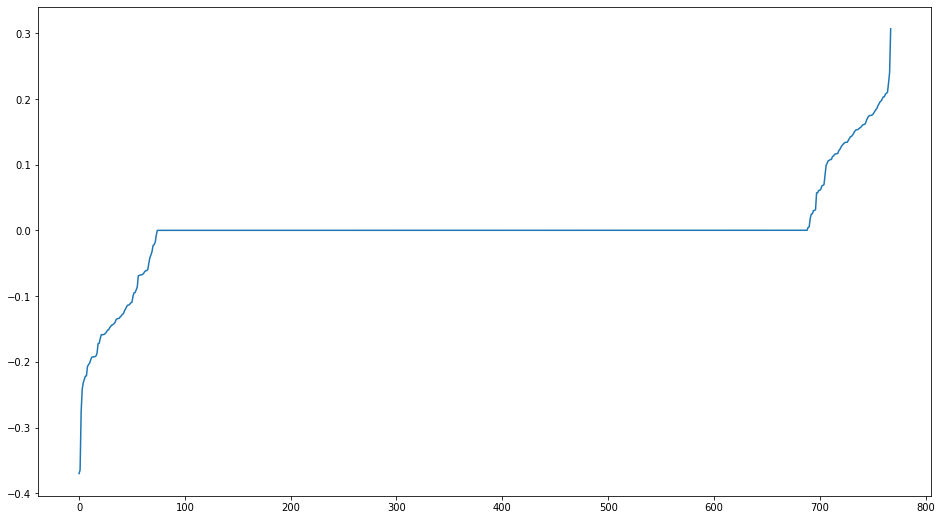

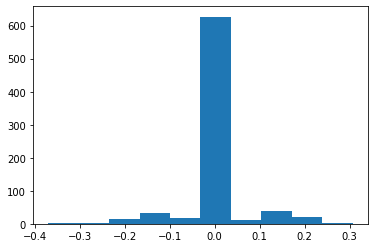

In [197]:
depth_probe_eigen = ckpt.depth_probe.numpy().ravel()

plt.figure(figsize=[16,9])
plt.plot(np.sort(depth_probe_eigen))
plt.show()
plt.hist(depth_probe_eigen)
plt.show()

## Orthogonal matrix (distance probe)

In [198]:
#languages = ['en', 'fr', 'de']
languages = ["en", "de", "es", "fi", "pl", "ar", "id", "zh", "ko"]
#out_dir = f'experiments/train_en_de_fr_ortho/task_depth-layer_{layer_idx}-trainl_en_de_fr/'
out_dir = f'experiments/train_9_langs/task_distance-layer_{layer_idx}-trainl_en_de_es_fi_pl_ar_id_zh_ko/'

model_dim = 768
probe_rank = 768

# DistanceProbe = tf.Variable(tf.random_uniform_initializer(minval=-0.05, maxval=0.05, seed=42)
#                              ((1, probe_rank)),
#                              trainable=True, name='distance_probe', dtype=tf.float32)

# DepthProbe = tf.Variable(tf.random_uniform_initializer(minval=-0.05, maxval=0.05, seed=42)
#                              ((1, probe_rank)),
#                              trainable=True, name='depth_probe', dtype=tf.float32)

DistanceProbe = tf.Variable(tf.random_uniform_initializer(minval=-0.5, maxval=0.5, seed=42)
                                ((1, probe_rank,)),
                                trainable=True, name='distance_probe', dtype=tf.float32)

DepthProbe = tf.Variable(tf.random_uniform_initializer(minval=-0.5, maxval=0.5, seed=42)
                                ((1, probe_rank,)),
                                trainable=True, name='depth_probe', dtype=tf.float32)

optimizer=tf.optimizers.Adam()

LanguageMaps = {lang: tf.Variable(tf.initializers.Identity(gain=1.0)((model_dim, model_dim)),
                                               trainable=False, name='{}_map'.format(lang))
                             for lang in languages}




                
ckpt = tf.train.Checkpoint(optimizer=optimizer, depth_probe=DepthProbe, distance_probe=DistanceProbe, **LanguageMaps)

checkpoint_manger = tf.train.CheckpointManager(ckpt, os.path.join(out_dir, 'params'), max_to_keep=1)

checkpoint_manger.restore_or_initialize()

'experiments/train_9_langs/task_distance-layer_6-trainl_en_de_es_fi_pl_ar_id_zh_ko/params/ckpt-11'

In [162]:
l1_projections =  l1_embeddings @ ckpt.de.numpy()
l2_projections = l2_embeddings @ ckpt.en.numpy()

In [200]:
l1_projections =  l1_embeddings @ ckpt.de.numpy() * (np.abs(ckpt.distance_probe.numpy()) > 0.1)
l2_projections = l2_embeddings @ ckpt.en.numpy() * (np.abs(ckpt.distance_probe.numpy()) > 0.1)

In [201]:
fr_map_distance = ckpt.de.numpy()
en_map_distance = ckpt.en.numpy()

In [202]:
xx2en_proj_acc , src_e, tgt_e = calc_alignment_accuracy(l1_projections, l2_projections)
print(xx2en_proj_acc)

0.1724470134874759


In [203]:
en2xx_proj_acc , src_e, tgt_e = calc_alignment_accuracy(l2_projections, l1_projections)
print(en2xx_proj_acc)

0.09633911368015415


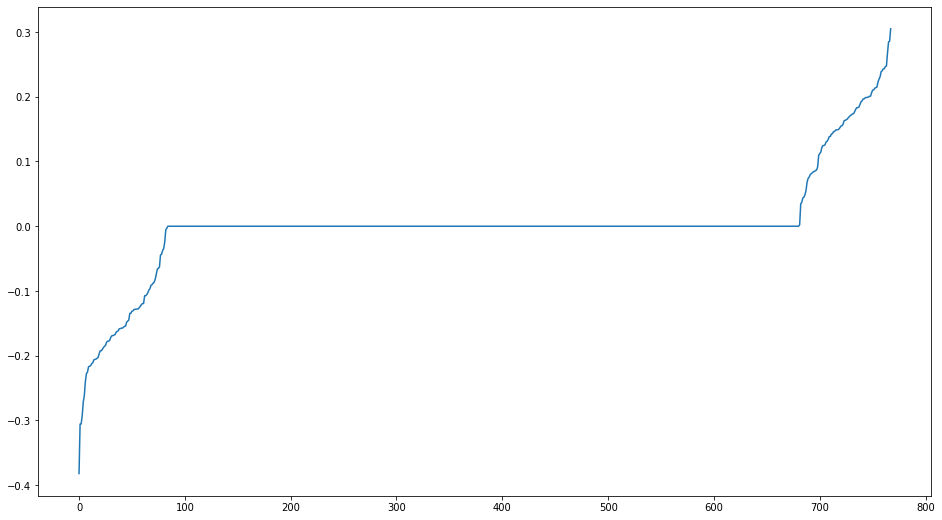

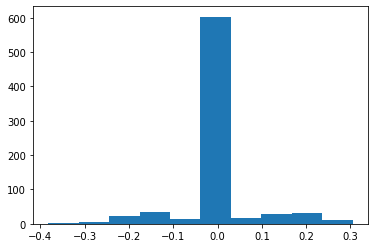

In [199]:
distance_probe_eigen = ckpt.distance_probe.numpy().ravel()

plt.figure(figsize=[16,9])
plt.plot(np.sort(distance_probe_eigen))
plt.show()
plt.hist(distance_probe_eigen)
plt.show()

## mean matrices

In [69]:
fr_map = (fr_map_depth + fr_map_distance)/ 2.
en_map = (en_map_depth + en_map_distance)/2.

In [70]:
l1_projections =  l1_embeddings @ fr_map
l2_projections = l2_embeddings @ en_map

In [71]:
xx2en_proj_acc , src_e, tgt_e = calc_alignment_accuracy(l1_projections, l2_projections)
print(xx2en_proj_acc)

0.7879440258342304


In [72]:
en2xx_proj_acc , src_e, tgt_e = calc_alignment_accuracy(l2_projections, l1_projections)
print(en2xx_proj_acc)

0.790096878363832
